In [38]:
from bs4 import BeautifulSoup
import sqlite3
import requests
import pandas as pd
from random import randint
import time
from time import sleep
from typing import List
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score
from scipy.stats import spearmanr

In [2]:
def sleepms(milliseconds: int):
    seconds = 0.001 * milliseconds
    sleep(seconds)
    
def random_wait():
    start = time.time()
    sleepms(randint(1, 350))

def getFakeUser():
    return {"User-Agent":"PostmanRuntime/7.29.0"}


def getRetHeaders():
    url='https://www.ret.co.il/m/91935/specs'
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    product=soup.find('div',class_='single-product-tab')
    data=product.findAll('ul','list-group list-group-horizontal')
    myheaders= ['מחיר מינימלי','מחיר מקסימלי']
    for alldata in data:
        myheaders.append(alldata.find('span',class_='text-dark font-weight-bold').text.strip())
    return myheaders


def getUrl(url):
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    MainClass=soup.find('ul', class_='nav nav-pills mb-2 justify-content-around justify-content-md-start col-xxl-10 offset-xxl-1 col-md-12 offset-md-0')
    ref=[]
    data=MainClass.find('a')
    technicalDataPage='https://www.ret.co.il'+data.get('href')
    return technicalDataPage

def getRetData(url):
    technicalDataPage=getUrl(url)
    page = requests.get(technicalDataPage, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    product=soup.find('div',class_='single-product-tab')
    dataLink=product.findAll('ul',class_='list-group list-group-horizontal')
    MinMaxP=MinMaxRetPrices(url)
    mydata=[MinMaxP[0],MinMaxP[1]]
    myheaders=[]
    for alldata in dataLink:
        try:
            mydata.append(alldata.find('li',class_='list-group-item col-8 rounded-0 text-600').text.strip())
        except:
             mydata.append('None')
    return mydata

def MinMaxRetPrices(url):
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    MainClass=soup.find('div',class_='')
    MainClass=soup.find('div',class_='card-body p-0 p-sm-3')
    price=MainClass.find('div',class_='price')
    if(price==None):
        return [None,None]
    else:
        price=price.text.strip()
        price=price.replace(',','')
        prices=price.split()
        MinPrice=prices[0]
        MaxPrice=prices[3]
        priceArray=MinPrice,MaxPrice
        return priceArray


In [3]:
def getRetToDataFrame(phonesURL):
    hrefLinks=[]
    allRetData=[]
    page = requests.get(phonesURL, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    MainClass=soup.findAll('a')
    for href in MainClass:
        if('/m/' in href.get('href')):
            hrefLinks.append('https://www.ret.co.il' + href.get('href'))
    for hrefLink in hrefLinks:
        allRetData.append(getRetData(hrefLink))
    return allRetData


In [4]:
def mainFunc(page_num_ret):
    head=getRetHeaders()
    url=f"https://www.ret.co.il/shop/cellphone?pageindex={page_num_ret}"
    data=getRetToDataFrame(url)
    df=pd.DataFrame(data,columns=head)
    return df

In [ ]:
df_ret=mainFunc(1)
for i in range(2,10):
    df_ret=df_ret.append(mainFunc(i))
    random_wait()

In [212]:
def get_headers():
    url="https://www.zap.co.il/compmodels.aspx?modelid=1142728"
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    All_headers=['מחיר מינימלי','מחיר מקסימלי']
    headers=soup.find_all('div',class_="detailsRow")
    for header in headers:
        All_headers.append(header.find('div',class_="detailsRowTitletxt").text.strip())
    return All_headers


In [213]:
def get_properites_from_link(url):
    All_data=[]
    All_headers=[]
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    headers=soup.find_all('div',class_="detailsRow")
    titles = ['מחיר מינימלי','מחיר מקסימלי']
    prices = soup.find('div','PricesTxt').findAll('span') 
    if len(prices) == 2:
        All_data = [ prices[1].text, prices[0].text ]
    elif len(prices) == 1: 
        All_data = [ prices[0].text, prices[0].text ]
    else:
        All_data = [ None,None ]
    for header in headers:
        All_headers.append(header.find('div',class_="detailsRowTitletxt").text.strip())
        All_data.append(header.find('div',class_="detailsRowTxt").text.strip())
    return All_data

In [214]:
def get_data_from_zap(phonesURL):
    hrefLinks=[]
    all_zap_Data=[]
    Main_Url="https://www.zap.co.il"
    page = requests.get(phonesURL, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    links=soup.find_all('div',class_="MoreInfo")
    for link in links:
        hrefLinks.append(Main_Url+(link.find('a')['href']))
    for link in hrefLinks:
        all_zap_Data.append(get_properites_from_link(link))
    return all_zap_Data
    

In [215]:
def get_details_from_current_page(page_num_zap):
    url="https://www.zap.co.il/models.aspx?sog=e-cellphone&pageinfo={page_num_zap}"
    data=get_data_from_zap(url)
    df=pd.DataFrame(data,columns=get_headers())
    return df


Changing all the headers in the DataFrame from Hebrew to English

In [231]:

def change_CSV_File_Headers(df):
    df.rename(columns={"פוקוס אוטומטי": "Autofocus"}, inplace=True)
    df.rename(columns={"פלאש": "Flash"}, inplace=True)
    df.rename(columns={"מצלמה": "Camera"}, inplace=True)
    df.rename(columns={"מפעיל": "operator"}, inplace=True)
    df.rename(columns={"דור": "Generation"}, inplace=True)
    df.rename(columns={"סוג רשת": "Network kind"}, inplace=True)
    df.rename(columns={"כרטיס SIM": "SIM"},inplace=True)
    df.rename(columns={"רדיו FM": "FM radio"}, inplace=True)
    df.rename(columns={"גובה": "height"}, inplace=True)
    df.rename(columns={"רוחב": "width"}, inplace=True)
    df.rename(columns={"עובי": "thickness"}, inplace=True)
    df.rename(columns={"משקל": "wheight"}, inplace=True)
    df.rename(columns={"קיבולת סוללה": "Battery capacity"}, inplace=True)
    df.rename(columns={"סוללה נשלפת": "Removable battery"}, inplace=True)
    df.rename(columns={"רמקול חיצוני": "External speaker"}, inplace=True)
    df.rename(columns={"חיבור 3.5": "connection 3.5"},inplace=True)
    df.rename(columns={"מחיר מינימלי": "Minprice"}, inplace=True)
    df.rename(columns={"מחיר מקסימלי": "Maxprice"}, inplace=True)
    df.rename(columns={"יצרן": "Brand"}, inplace=True)
    df.rename(columns={"שנת הכרזה": "Declaration year"}, inplace=True)
    df.rename(columns={"מערכת הפעלה": "Operating System"}, inplace=True)
    df.rename(columns={"סדרה": "series"}, inplace=True)
    df.rename(columns={"מבנה המכשיר": "device structure"},inplace=True)
    df.rename(columns={"ממשק הפעלה": "operating interfaceo"}, inplace=True)
    df.rename(columns={"נפח אחסון פנימי": "Internal storage volume"}, inplace=True)
    df.rename(columns={"ערכת שבבים": "chipset"}, inplace=True)
    df.rename(columns={"צבעים": "colors"}, inplace=True)
    df.rename(columns={"טלפון כשר": "kosher phone"}, inplace=True)
    df.rename(columns={"רמת קרינה (SAR)": "radiation level"}, inplace=True)
    df.rename(columns={"טלפון למבוגרים": "Phone for adults"}, inplace=True)
    df.rename(columns={"מאיץ גרפי": "Graphics accelerator"}, inplace=True)
    df.rename(columns={"מהירות מעבד": "CPU speed"},inplace=True)
    df.rename(columns={"עמידות במים": "Water resistance"}, inplace=True)
    df.rename(columns={"קורא טביעת אצבע": "Fingerprint reader"},inplace=True)
    df.rename(columns={"גודל מסך": "screen size"}, inplace=True)
    df.rename(columns={"סוג מסך": "screen type"}, inplace=True)
    df.rename(columns={"קצב רענון": "refresh rate"}, inplace=True)
    df.rename(columns={"צפיפות פיקסלים": "Pixel density"}, inplace=True)
    df.rename(columns={"מפתח צמצם": "Aperture key"}, inplace=True)
    df.rename(columns={"מעבד": "Processor"}, inplace=True)
    df.rename(columns={"רזולוציה": "resolution"},inplace=True)
    df.rename(columns={"כרטיס זיכרון":"Memory Card"}, inplace=True)
    df.rename(columns={"זיכרון RAM": "RAM memory"}, inplace=True)
    df.rename(columns={"וידאו": "video"}, inplace=True)
    df.rename(columns={"קיבולת הסוללה": "battery capacity"}, inplace=True)
    df.rename(columns={"מספר ליבות": "number of cores"}, inplace=True)
    df.rename(columns={"מצלמה קדמית": "front camera"}, inplace=True)
    df.rename(columns={"טעינה אלחוטית": "wireless charging"}, inplace=True)
    df.to_csv("PhonesDF.csv",index=False)


In [ ]:
df_zap=get_details_from_current_page(1)
for i in range(2,21):
    df_zap=df_zap.append(get_details_from_current_page(i))
    random_wait()

Saving the first DataFrame before cleaning

In [5]:
def SaveDataFrame(df):
    df=df_zap.append(df_ret)
    df.to_csv('PhonesDF.csv',header=True)
    df=pd.read_csv('PhonesDF.csv')
    change_CSV_File_Headers(df)
    df=pd.read_csv('PhonesDF.csv')
    df


Function to clean all the Data Frame None price columns

In [2]:
def CleanTheDF(df):
    df=df.drop_duplicates()
    df.dropna(axis=0, how='all')# if all the values are None remove this row
    df=df.dropna(subset=['Minprice','Maxprice'],how ='all')
    df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
    df.to_csv('SmallPhonesDF.csv')
    return df

In [184]:
df=pd.read_csv('PhonesDF.csv')
Smalldf=CleanTheDF(df)
Smalldf

,Minprice,Maxprice,Brand,Operating System,Declaration year,device structure,series,Smartphone,radiation level,operating interfaceo,...,External speaker,FM radio,height,width,thickness,wheight,battery capacity,Removable battery,wireless charging,Dual-SIM
0,"3,458","4,649",Samsung,Android,2022,פאבלט,Galaxy S22,סמארטפון,1.05 W/kg,מסך מגע,...,זוג רמקולים,יעודכן בקרוב,"163.3 מ""מ","77.9 מ""מ","8.9 מ""מ",228 גרם,"5,000 mAh",לא,כולל,NaN
1,"2,774","3,499",Apple,iOS,2021,פאבלט,iPhone 13,סמארטפון,יעודכן בקרוב,מסך מגע,...,זוג רמקולים,ללא רדיו,"146.7 מ""מ","71.5 מ""מ","7.7 מ""מ",174 גרם,לא זמין,לא,כולל,NaN
2,"5,795","6,699",Apple,iOS,2022,פאבלט,iPhone 14 Pro Max,סמארטפון,לא זמין,מסך מגע,...,זוג רמקולים,ללא רדיו,"160.7 מ""מ","77.6 מ""מ","7.9 מ""מ",240 גרם,לא זמין,לא,כולל,NaN
3,"1,510","1,949",Samsung,Android,2022,פאבלט,Galaxy A73,סמארטפון,1.28 W/kg,מסך מגע,...,יחיד,יעודכן בקרוב,"163.7 מ""מ","76.1 מ""מ","7.6 מ""מ",181 גרם,"5,000 mAh",לא,ללא,NaN
4,"3,193","3,965",Apple,iOS,2022,פאבלט,iPhone 14,סמארטפון,לא זמין,מסך מגע,...,זוג רמקולים,ללא רדיו,"146.7 מ""מ","71.5 מ""מ","7.8 מ""מ",172 גרם,לא זמין,לא,כולל,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879,1899,1899,Samsung,Android,None,פאבלט,None,סמארטפון,None,מסך מגע,...,יחיד,None,"163.7 מ""מ","76.1 מ""מ","7.6 מ""מ",181 גרם,"5,000 mAh",לא,None,None
880,1180,1180,Samsung,Android,2021,פאבלט,Galaxy A52,סמארטפון,1.05 W/kg,מסך מגע,...,זוג רמקולים,כולל רדיו,"159.9 מ""מ","75.1 מ""מ","8.4 מ""מ",189 גרם,"4,500 mAh",לא,None,None
881,5949,5949,Samsung,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
882,1799,1449,Xiaomi,Android,None,פאבלט,None,סמארטפון,None,מסך מגע,...,זוג רמקולים,None,"164.2 מ""מ","76.1 מ""מ","8.1 מ""מ",202 גרם,"5,000 mAh",לא,ללא,כולל


Cleaning and converting to Numeric

In [185]:
def cleaning_to_numeric(df):
    df['radiation level']=pd.to_numeric(df['radiation level'].str.replace('W/kg','').str.strip(),errors='coerce')
    df['height']=pd.to_numeric(df['height'].str.replace('מ"מ','').str.strip(),errors='coerce')
    df['Internal storage volume']=pd.to_numeric(df['Internal storage volume'].str.replace('GB','').str.replace('1TB','1000').str.strip(),errors='coerce')
    df['RAM memory']=pd.to_numeric(df['RAM memory'].str.replace('GB','').str.strip(),errors='coerce')
    df['width']=pd.to_numeric(df['width'].str.replace('מ"מ','').str.strip(),errors='coerce')
    df['thickness']=pd.to_numeric(df['thickness'].str.replace('מ"מ','').str.strip(),errors='coerce')
    df['wheight']=pd.to_numeric(df['wheight'].str.replace('גרם','').str.strip(),errors='coerce')
    df['refresh rate']=pd.to_numeric(df['refresh rate'].str.replace('Hz','').str.strip(),errors='coerce')
    df['Pixel density']=pd.to_numeric(df['Pixel density'].str.replace('ppi','').str.strip(),errors='coerce')
    df['number of cores']=df['number of cores'].apply(lambda x: x.removesuffix(' ליבות') if x else None) 
    df['screen size']=pd.to_numeric(df['screen size'].str.replace('אינטש','').str.strip(),errors='coerce')
    df['Network kind']=pd.to_numeric(df['Network kind'].str.replace('G','').str.strip(),errors='coerce')
    df['front camera']=pd.to_numeric(df['front camera'].str.replace('מגה פיקסל','').str.strip(),errors='coerce')
    df['Flash']=pd.to_numeric(df['Flash'].str.replace('לדים','').str.strip(),errors='coerce')
    df['resolution']=df['resolution'].apply(lambda x: x.removesuffix(' פיקסלים'))
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' מגה פיקסל') if x else None)
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' מגה פיקסלים') if x else None)
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' צגה פיקסל') if x else None)
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' גה פיקסל') if x else None)
    df['CPU speed']=df['CPU speed'].apply(lambda x: x.split()[0] if x else None)
    df['battery capacity']=df['battery capacity'].apply(lambda x: x.removesuffix(' mAh')if x else None)
    df['battery capacity']=pd.to_numeric(df['battery capacity'].str.replace(',','').str.strip(),errors='coerce') 
    df['Minprice']=pd.to_numeric(df['Minprice'].str.replace(',','').str.strip(),errors='coerce')
    df['Maxprice']=pd.to_numeric(df['Maxprice'].str.replace(',','').str.strip(),errors='coerce')
    return df



In [186]:
df_WithNone = Smalldf.copy()
for col in df_WithNone:
    df_WithNone.loc[(df_WithNone[col] == 'לא זמין') |(df_WithNone[col] == 'יעודכן בקרוב'),col]=None
df_WithNone=cleaning_to_numeric(df_WithNone)
df_WithNone["Autofocus"] =  np.where(df_WithNone['Autofocus']  == "כולל" , 1 , 0)
df_WithNone["connection 3.5"] =  np.where(df_WithNone['connection 3.5']  == "ללא" , 0 , 1)
df_WithNone["Dual-SIM"] =  np.where(df_WithNone['Dual-SIM']  == "ללא" , 0 , 1)
df_WithNone["Memory Card"] =  np.where(df_WithNone['Memory Card']  == "ללא" , 0 , 1)
df_WithNone["Fingerprint reader"] =  np.where(df_WithNone['Fingerprint reader']  == "ללא" , 0 , 1)
df_WithNone["WiFi"] =  np.where(df_WithNone['WiFi']  == "כולל" , 1 , 0)
df_WithNone["IR"] =  np.where(df_WithNone['IR']  == "לא כולל" , 0 , 1)
df_WithNone["GPS"] =  np.where(df_WithNone['GPS']  == "כולל" , 1 , 0)
df_WithNone["NFC"] =  np.where(df_WithNone['NFC']  == "כולל" , 1 , 0)
df_WithNone["FM radio"] =  np.where(df_WithNone['FM radio']  == "ללא רדיו" , 0 , 1)
df_WithNone["Removable battery"] =  np.where(df_WithNone['Removable battery']  == "לא" , 0 , 1)
df_WithNone["External speaker"] =  np.where(df_WithNone['External speaker']  == "ללא" , 0 , 1)
df_WithNone["kosher phone"] =  np.where(df_WithNone['kosher phone']  == "טלפון כשר" , 1, 0)
df_WithNone["colors"] = np.where( df_WithNone['colors']!= None, 1, 0)
df_WithNone["Smartphone"] = np.where( df_WithNone['Smartphone']== "סמארטפון", 1, 0)
df_WithNone["operating interfaceo"] = np.where( df_WithNone['operating interfaceo']!= 'None', 1, 0)
df_WithNone["device structure"] = np.where( df_WithNone['device structure']== "פאבלט", 1, 0)
df_WithNone["wireless charging"] =  np.where(df_WithNone['wireless charging']  == "כולל" , 1 , 0)
df_WithNone["Bluetooth"] =  np.where(df_WithNone['Bluetooth']  != 'None' , 1 , 0)
df_WithNone["Phone for adults"] =  np.where(df_WithNone['Phone for adults'] =='טלפון למבוגרים' , 1,0)


for i in df_WithNone.index:
    try:
        df_WithNone['number of cores'][i]=eval(df_WithNone['number of cores'][i])
    except:
        df_WithNone['number of cores'][i]=None
for i in df_WithNone.index:
    try:
        df_WithNone['Camera'][i]=eval(df_WithNone['Camera'][i])
    except:
        df_WithNone['Camera'][i]=None
for i in df_WithNone.index:
        try:
            df_WithNone['resolution'][i]=eval(df_WithNone['resolution'][i].replace('x','*'))
        except: 
            if df_WithNone['resolution'][i]!= None:
                a = df_WithNone['resolution'][i].split('x')
                b = a[1].split('\u200f')
                df_WithNone['resolution'][i]=(int(a[0])*int(b[0]))


    

C:\Users\eranb\AppData\Local\Temp\ipykernel_3500\1443733727.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_WithNone['number of cores'][i]=eval(df_WithNone['number of cores'][i])
C:\Users\eranb\AppData\Local\Temp\ipykernel_3500\1443733727.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_WithNone['number of cores'][i]=None
C:\Users\eranb\AppData\Local\Temp\ipykernel_3500\1443733727.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

After using the pd.to_numeric all the values that werent changed got changed into NAN values and we also saw that we good 'None' values as a string insted of None this rows change them back to None

In [187]:
df_WithNone=df_WithNone.replace('None',np.nan)
df_WithNone=df_WithNone.replace({None:np.nan})
df_WithNone = df_WithNone.replace({'ללא': 'Without'})
df_WithNone = df_WithNone.replace({'כולל': 'Included'})
df_WithNone = df_WithNone.replace({'SIM אחד , eSIM': 'eSIM'})
df_WithNone = df_WithNone.replace({'Dual SIM אופציונלי': 'Optional Dual SIM'})


In [188]:
def to_numeric_second_time(df,cols):
    for col in cols:
        df[col]=pd.to_numeric(df[col])
    return df

In [189]:
list_describe=df_WithNone.describe().columns
all_cols=df_WithNone.columns
listNotInDescribe=[]
for col in all_cols:
    if(col not in list_describe):
        listNotInDescribe.append(col)
print(listNotInDescribe)

# יש ערכים שצריכים להיות נומרים אבל הם לא לכן נריץ שוב
listThatShouldBe=['Declaration year','CPU speed','Generation']
df_WithNone=to_numeric_second_time(df_WithNone,listThatShouldBe)

list_describe=df_WithNone.describe().columns
all_cols=df_WithNone.columns
listNotInDescribe=[]
for col in all_cols:
    if(col not in list_describe):
        listNotInDescribe.append(col)
len(listNotInDescribe)

['Brand', 'Operating System', 'Declaration year', 'series', 'chipset', 'Processor', 'CPU speed', 'Graphics accelerator', 'Water resistance', 'screen type', 'SIM', 'Generation', 'operator', 'Aperture key', 'video']


12

In [190]:
#pd.set_option('display.max_rows',None)
#pd.set_option('display.max_columns',None)


Lets check columns that might effect our data

In [191]:
nan_count = df_WithNone['SIM'].isnull().sum()
nan_count

401

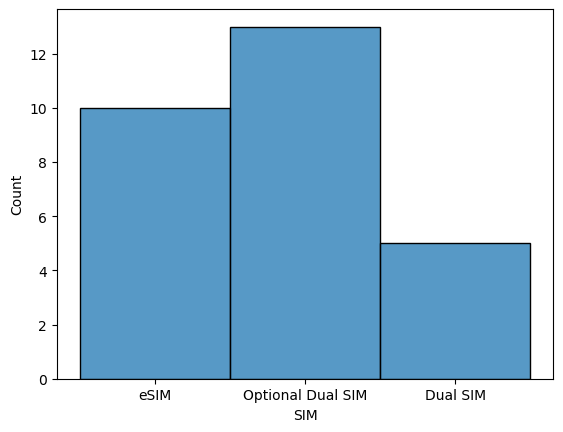

In [192]:
sns.histplot(df_WithNone['SIM'])
plt.show()

We can see that the 'SIM' have big ammounts on NaN values. lets drop this column:

In [193]:
df_WithNone.drop('SIM',axis=1,inplace=True)

In [194]:
df_WithNone['Declaration year']

0      2022.0
1      2021.0
2      2022.0
3      2022.0
4      2022.0
        ...  
879       NaN
880    2021.0
881       NaN
882       NaN
883       NaN
Name: Declaration year, Length: 429, dtype: float64

In [195]:
nan_count = df_WithNone['Declaration year'].isnull().sum()
nan_count

119

It is alot of rows that will be deleted if we will not change it.

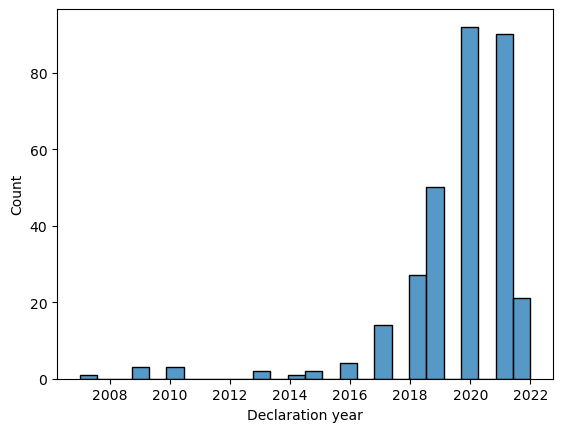

In [196]:
sns.histplot(df_WithNone['Declaration year'])
plt.show()

Looks like that most of the Phones are from the resent years. lets fill the missing rows with the meadian of this column but we will casting it to int.

In [197]:
avgsotrage=int(df_WithNone['Declaration year'].mean())
avgsotrage
df_WithNone['Declaration year']= df_WithNone['Declaration year'].fillna(avgsotrage)

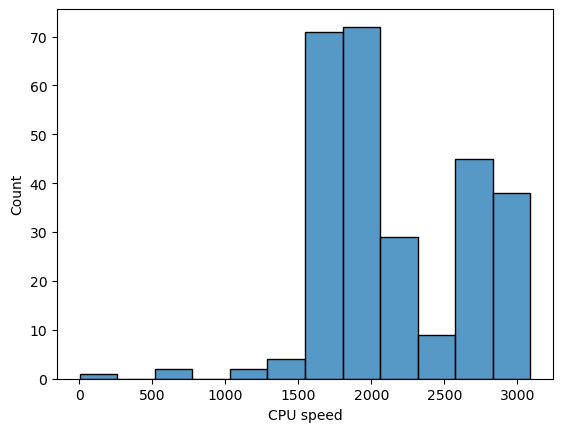

In [198]:
sns.histplot(df_WithNone['CPU speed'])
plt.show()


4.0
512.0


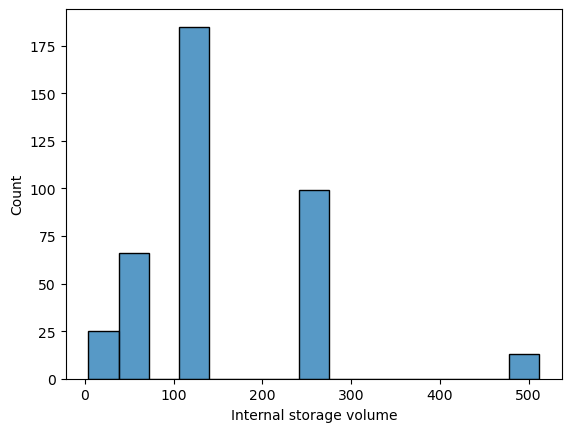

In [199]:
print(df_WithNone['Internal storage volume'].min())
print(df_WithNone['Internal storage volume'].max())

sns.histplot(df_WithNone['Internal storage volume'])
plt.show()

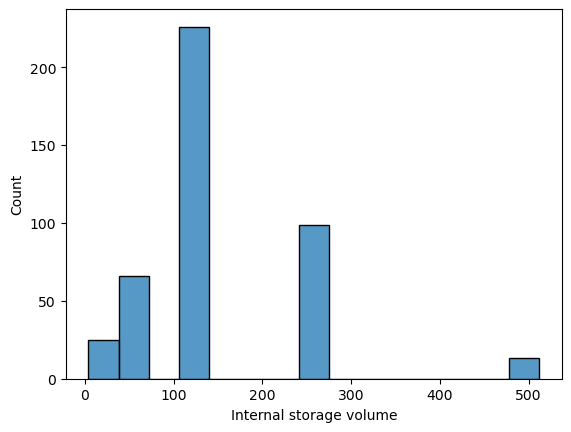

In [200]:
avgsotrage=df_WithNone['Internal storage volume'].mode()[0]
df_WithNone['Internal storage volume']= df_WithNone['Internal storage volume'].fillna(avgsotrage)
sns.histplot(df_WithNone['Internal storage volume'])
plt.show()

We decided to combain the MinPrice and MaxPrice into an avarage price.

In [201]:
dfUnionPrice=df_WithNone.copy()
dfUnionPrice['Price']=(dfUnionPrice['Minprice'] + dfUnionPrice['Maxprice'])/2
dfUnionPrice=dfUnionPrice.drop(['Minprice','Maxprice'],axis=1)
dfUnionPrice.describe()

,Declaration year,device structure,Smartphone,radiation level,operating interfaceo,kosher phone,colors,Phone for adults,Internal storage volume,number of cores,...,FM radio,height,width,thickness,wheight,battery capacity,Removable battery,wireless charging,Dual-SIM,Price
count,429.000000,429.000000,429.000000,127.000000,429.000000,429.000000,429.0,429.000000,429.000000,298.000000,...,429.000000,378.000000,392.000000,398.000000,398.000000,347.000000,429.000000,429.000000,429.000000,429.000000
mean,2019.405594,0.811189,0.890443,0.698228,0.962704,0.020979,1.0,0.037296,153.454545,7.604027,...,0.426573,155.932540,73.401786,8.654749,183.820352,4110.458213,0.104895,0.370629,0.752914,1894.544289
std,1.875460,0.391815,0.312702,0.376060,0.189707,0.143481,0.0,0.189707,94.068830,1.109001,...,0.495157,13.239346,7.871352,2.745878,30.772489,1158.255560,0.306776,0.483537,0.431821,1399.096567
min,2007.000000,0.000000,0.000000,0.220000,0.000000,0.000000,1.0,0.000000,4.000000,2.000000,...,0.000000,76.000000,44.700000,6.400000,70.200000,430.000000,0.000000,0.000000,0.000000,108.000000
25%,2019.000000,1.000000,1.000000,0.360000,1.000000,0.000000,1.0,0.000000,128.000000,8.000000,...,0.000000,151.700000,71.725000,7.800000,174.250000,3700.000000,0.000000,0.000000,1.000000,849.500000
50%,2019.000000,1.000000,1.000000,0.590000,1.000000,0.000000,1.0,0.000000,128.000000,8.000000,...,0.000000,160.200000,74.800000,8.200000,189.000000,4500.000000,0.000000,0.000000,1.000000,1494.000000
75%,2021.000000,1.000000,1.000000,0.990000,1.000000,0.000000,1.0,0.000000,256.000000,8.000000,...,1.000000,163.700000,76.100000,8.800000,199.000000,5000.000000,0.000000,1.000000,1.000000,2563.000000
max,2022.000000,1.000000,1.000000,1.630000,1.000000,1.000000,1.0,1.000000,512.000000,10.000000,...,1.000000,192.700000,128.200000,54.000000,282.000000,6000.000000,1.000000,1.000000,1.000000,7850.000000


In [202]:
iscol=[i for i in dfUnionPrice.columns]
# Distinct between numerical and categorical variables
Numericals=[]
Categoricals=[]
for x in iscol :
  data = pd.DataFrame(dfUnionPrice)
  if (type(dfUnionPrice[x][0]) == np.dtype(int) or type(data[x][0]) == np.dtype(float)) and data[x].nunique()>=4:
    Numericals.append(x)
  else:
    Categoricals.append(x)

In [203]:
# Depiction of the Numericals variables in a statistical method
NumericalData = pd.DataFrame(data,columns=Numericals)
data_describe=NumericalData.describe().loc[['mean','50%','min','max','std'],:]
IQR = []
for x in NumericalData.columns:
  q1,q3=np.percentile(NumericalData[x],[25,75])
  IQR.append(q3-q1)
data_describe.loc["IQR"] = IQR
data_describe

,Declaration year,radiation level,Internal storage volume,number of cores,CPU speed,RAM memory,screen size,resolution,Pixel density,refresh rate,Generation,Camera,front camera,height,width,thickness,wheight,battery capacity,Price
mean,2019.405594,0.698228,153.454545,7.604027,2186.560806,6.425532,6.070352,2.481043e+06,393.634271,107.370166,4.143223,51.747286,17.275862,155.932540,73.401786,8.654749,183.820352,4110.458213,1894.544289
50%,2019.000000,0.590000,128.000000,8.000000,2000.000000,6.000000,6.450000,2.592000e+06,403.000000,120.000000,4.000000,52.000000,12.000000,160.200000,74.800000,8.200000,189.000000,4500.000000,1494.000000
min,2007.000000,0.220000,4.000000,2.000000,1.100000,2.000000,1.770000,1.920000e+04,111.000000,60.000000,2.000000,0.300000,8.000000,76.000000,44.700000,6.400000,70.200000,430.000000,108.000000
max,2022.000000,1.630000,512.000000,10.000000,3090.000000,16.000000,7.600000,4.631040e+06,570.000000,144.000000,5.000000,210.000000,40.000000,192.700000,128.200000,54.000000,282.000000,6000.000000,7850.000000
std,1.875460,0.376060,94.068830,1.109001,477.522536,2.667291,1.142000,1.102926e+06,87.687304,16.964702,0.472255,35.919307,10.201178,13.239346,7.871352,2.745878,30.772489,1158.255560,1399.096567
IQR,2.000000,NaN,128.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1713.500000


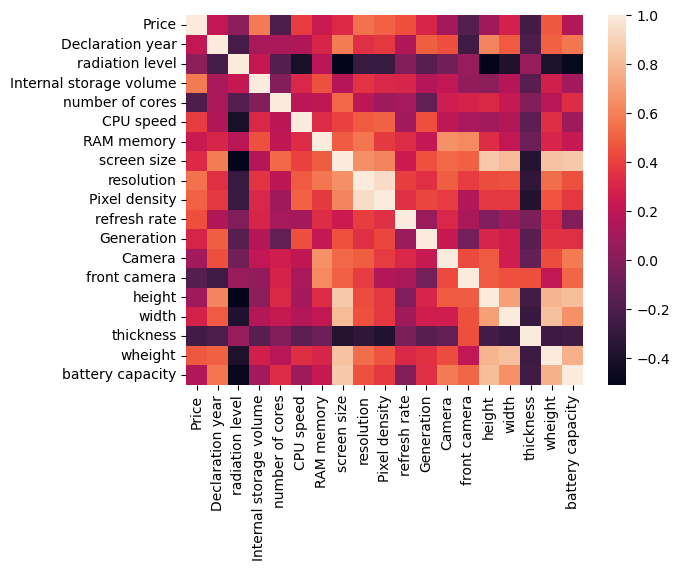

In [204]:
def create_heatmap(numeric_df):
    first_col = numeric_df.pop('Price')
    numeric_df.insert(0, 'Price', first_col)
    sns.heatmap(numeric_df.corr())
    
PhonesHeatmap = NumericalData.select_dtypes(include='number')
create_heatmap(PhonesHeatmap)

Lets check if we got some columns which have correlation above 0.7. If so we will check for each column the ammount of influence on our Price column to see if we can delete any of them.

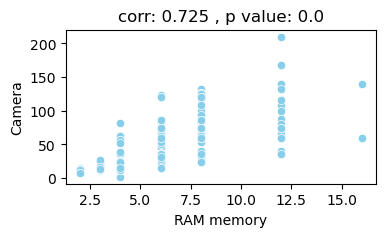

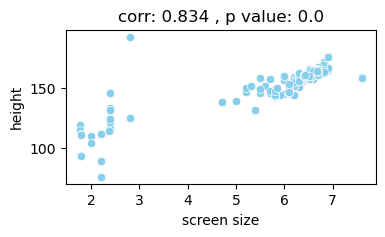

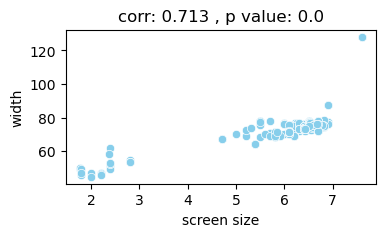

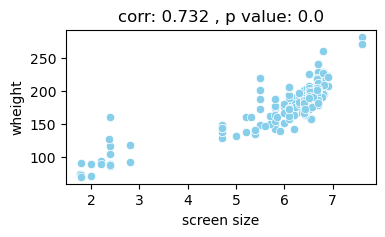

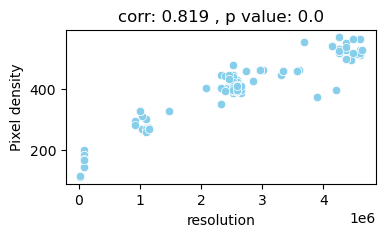

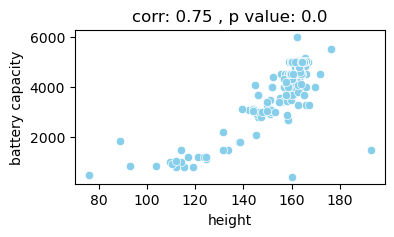

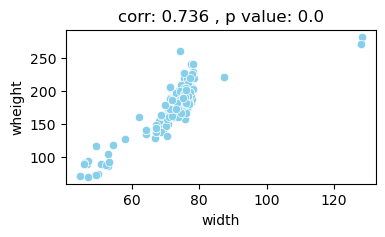

In [210]:
# Checking if there is a correlation above 0.7
tmp = []
for var1 in Numericals:
    for var2 in Numericals:
        if var1 != var2:
            # Check if the pair has already been plotted
            if (var1, var2) not in tmp and (var2, var1) not in tmp:
                item = list(set([var1, var2]))
                tmp.append((var1, var2))  # Add the pair to tmp
                corr, p = spearmanr(data[var1], data[var2], nan_policy='omit')
                title = 'corr: ' + str(round(corr,3)) + ' , ' +  'p value: ' + str(round(p,3))
                if corr > 0.7:
                    plt.figure(figsize=(4,2))
                    try:
                        sns.scatterplot(data=data, x=var1, y=var2, color='skyblue')
                        plt.title(title)
                        plt.show()
                    except:
                        pass

Looks like Width,wheight and screen size will influance almost in the same way, also battery capacity,height ----- resultion,pixel dencity ----Ram memory,camera. 
lets check if some of those columns will effect on our data in a negative way First lets check the ammount of NaN rows for each column and if the ammount of row is high we will check the correlation of those rows on our 'Price' column, if its low we will remove them.  

In [206]:
Group1=['Width','Wheight','screen size']
Group2=['resolution','pixel dencity']
Group3=['RAM memory','Camera']
width=dfUnionPrice['width'].isnull().sum()
wheight=dfUnionPrice['wheight'].isnull().sum()
screen_size=dfUnionPrice['screen size'].isnull().sum()
resolution=dfUnionPrice['resolution'].isnull().sum()
Pixel_density=dfUnionPrice['Pixel density'].isnull().sum()
RAM_memory=dfUnionPrice['RAM memory'].isnull().sum()
Camera=dfUnionPrice['Camera'].isnull().sum()
print('NaN count for those rows:\n''Width: ',width,'\nWheight:',wheight,'\nscreen_size:',screen_size,'\nresolution:',resolution,'\nPixel density:',Pixel_density,'\nRAM_memory:',RAM_memory,'\nCamera:',Camera)



NaN count for those rows:
Width:  37 
Wheight: 31 
screen_size: 31 
resolution: 54 
Pixel density: 38 
RAM_memory: 53 
Camera: 79


Looks like Camera might have a big influance on our data, lets check the correlation between the 'camera' and 'Price' and 'RAM memory' and 'Price', if its low we can drop the Camera column to stay with a bigger ammount of rows.

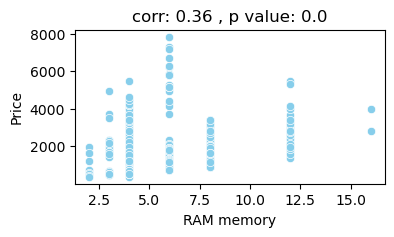

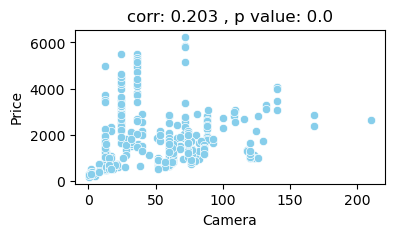

In [213]:
plt.figure(figsize=(4,2))
corr, p = spearmanr(data['RAM memory'], data['Price'], nan_policy='omit')
title = 'corr: ' + str(round(corr,3)) + ' , ' +  'p value: ' + str(round(p,3))
try:
    sns.scatterplot(data=data, x='RAM memory', y='Price', color='skyblue')
    plt.title(title)
    plt.show()
except:
    pass

plt.figure(figsize=(4,2))
corr, p = spearmanr(data['Camera'], data['Price'], nan_policy='omit')
title = 'corr: ' + str(round(corr,3)) + ' , ' +  'p value: ' + str(round(p,3))
try:
    sns.scatterplot(data=data, x='Camera', y='Price', color='skyblue')
    plt.title(title)
    plt.show()
except:
    pass


Looks like we can drop the camera from our Dataframe.

In [155]:
dfUnionPrice.drop('Camera',axis=1,inplace=True)
NumericalData.drop('Camera',axis=1,inplace=True)

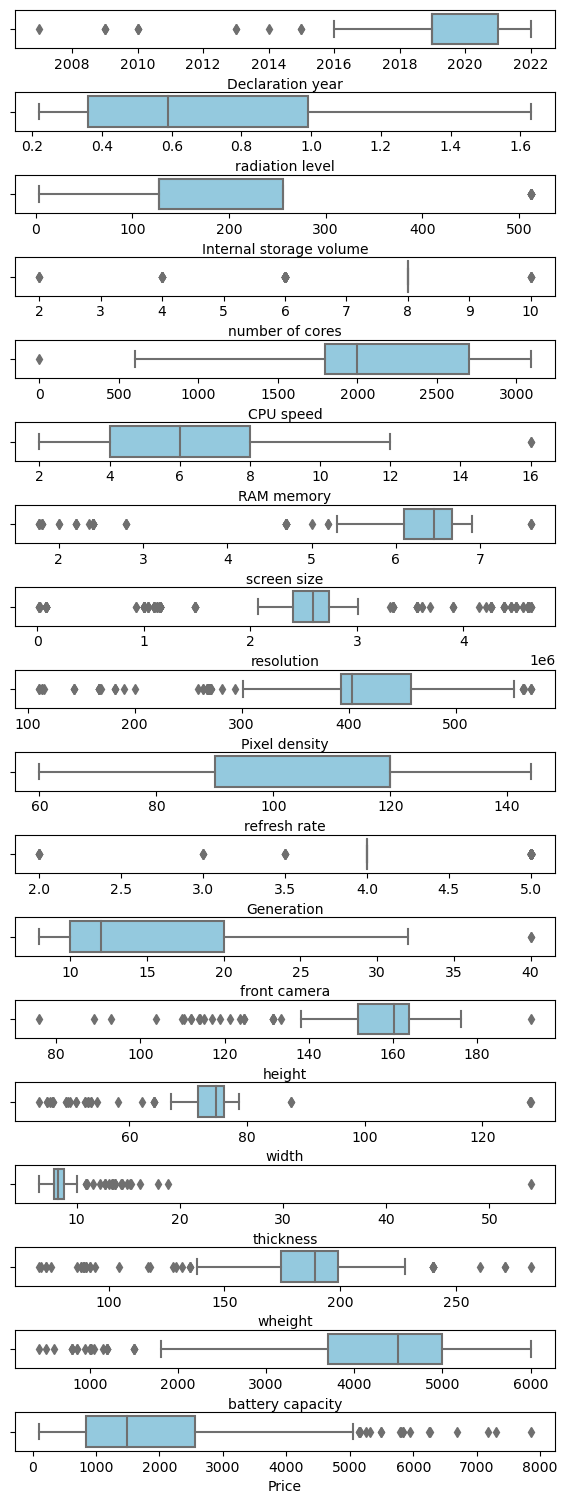

In [157]:
# Depiction of the Numericals variables in a graphical method
cols = NumericalData.columns
fig, ax = plt.subplots(len(cols),1, figsize = (6,15))
plt.tight_layout()

for i , col in enumerate(cols):
    sns.boxplot(data = NumericalData, x = col, ax = ax[i], color = 'skyblue')

Now lets check all the categorical columns that we have

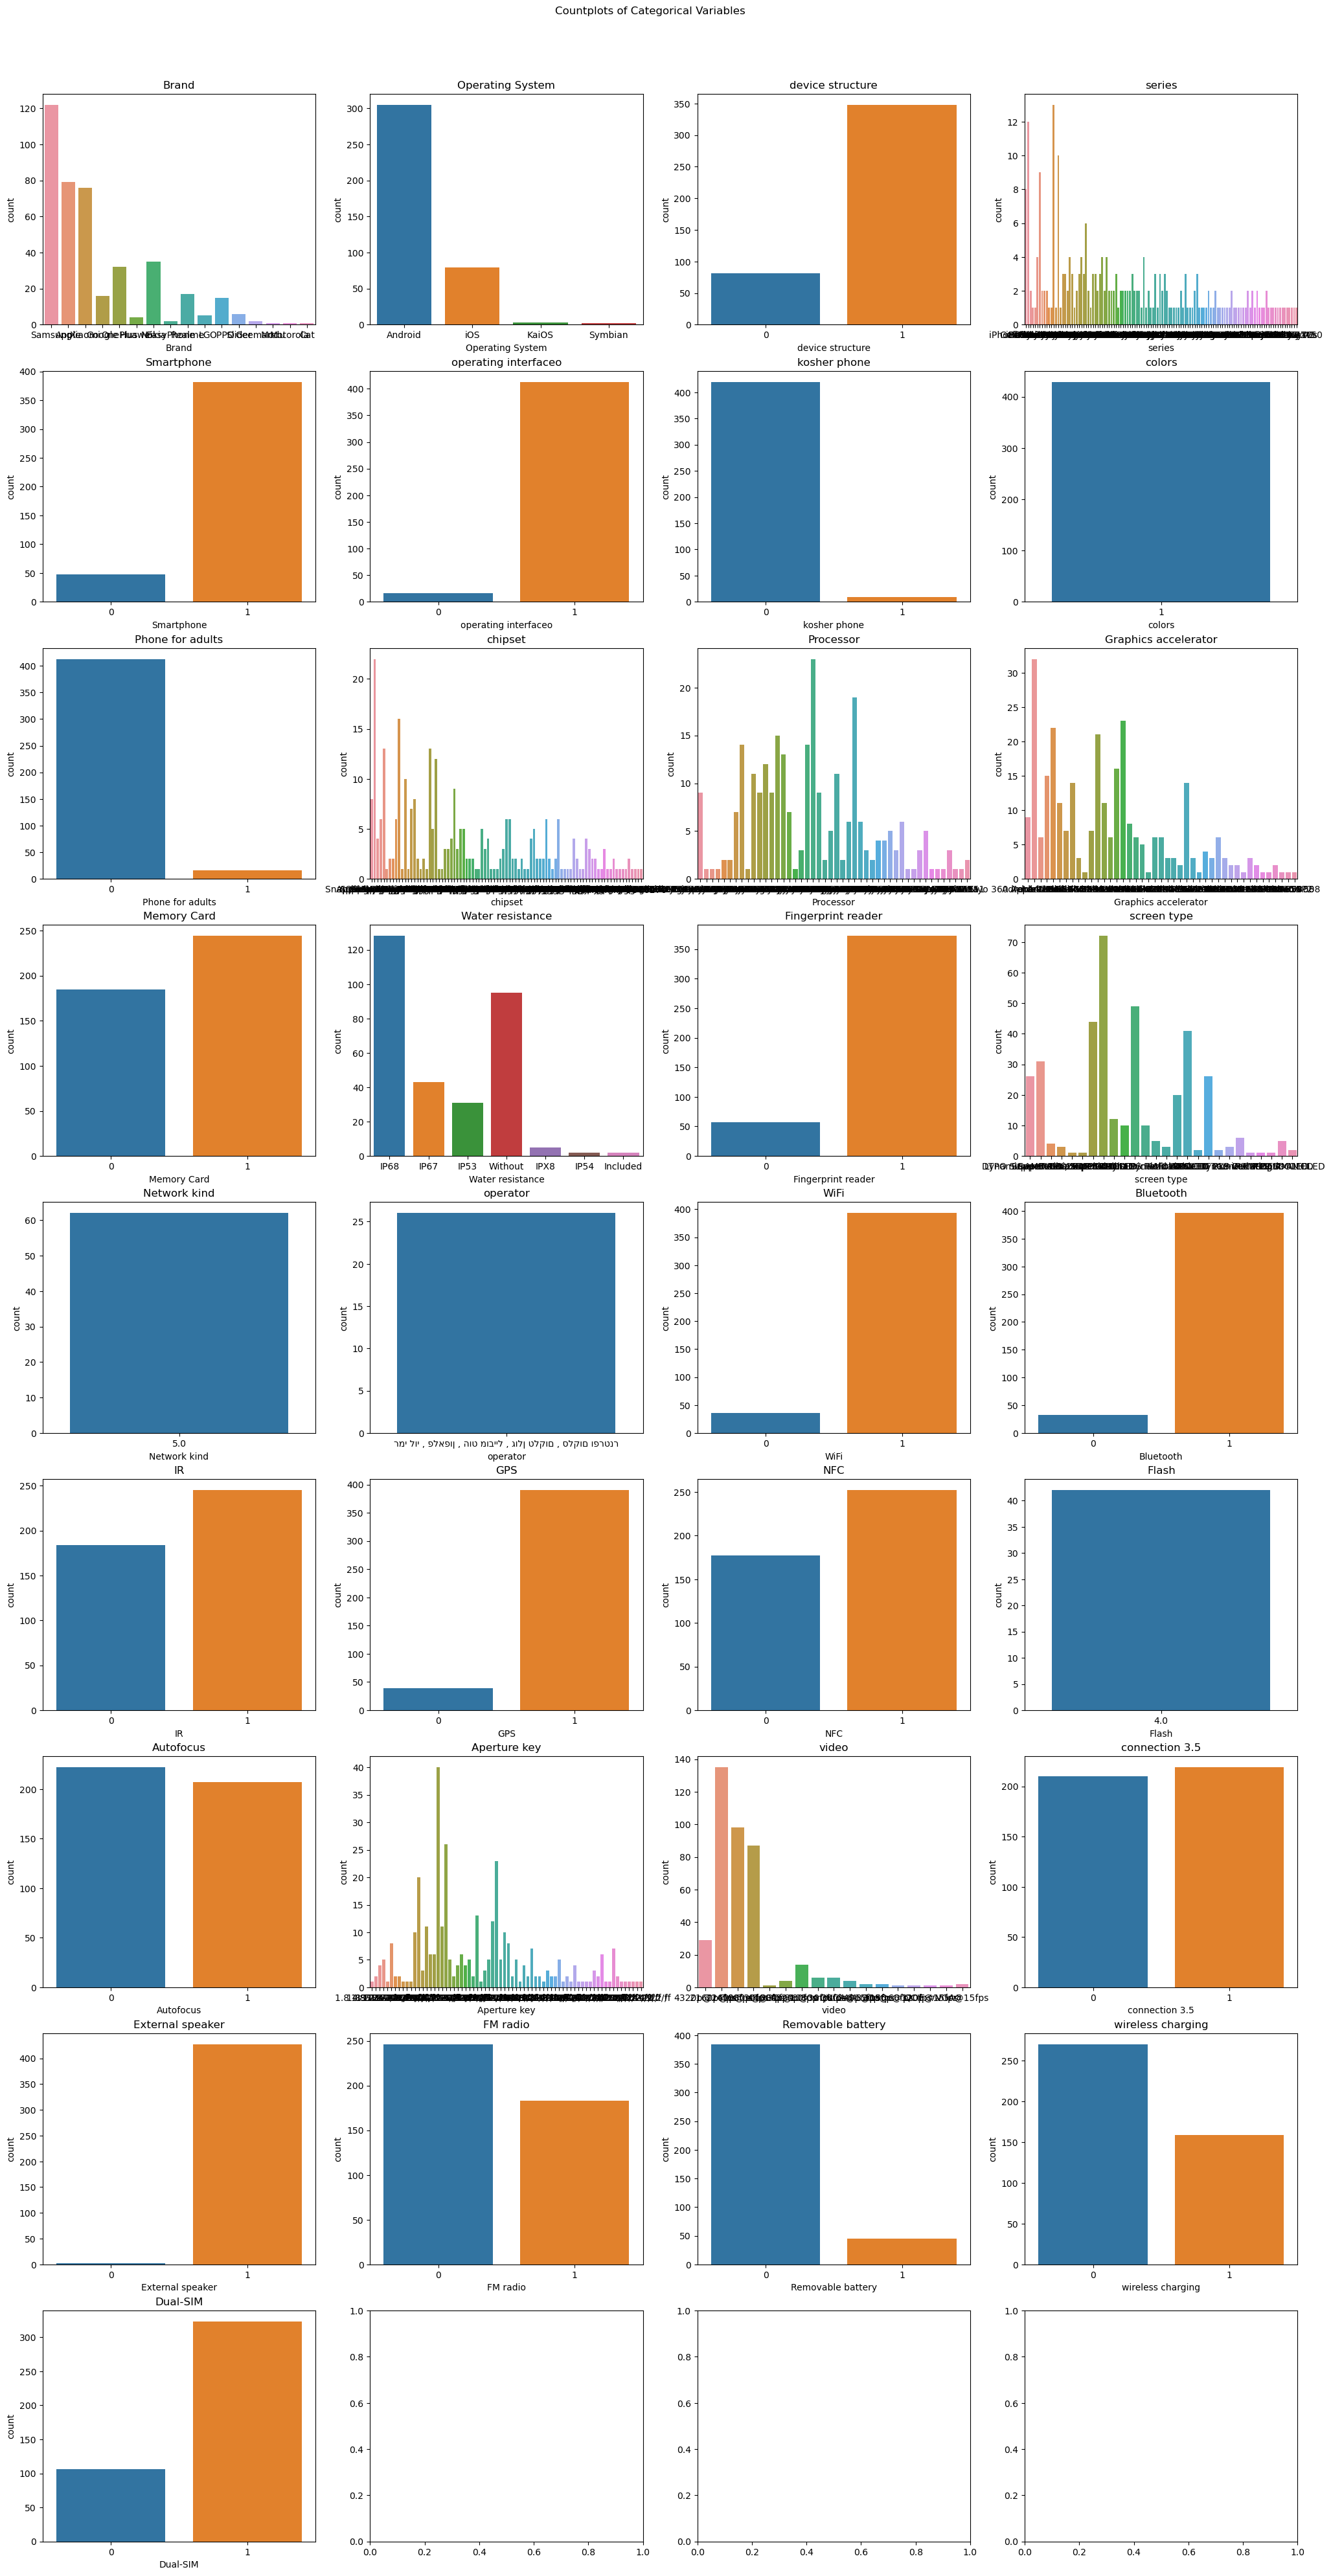

In [158]:
len(Categoricals)
n_plots = len(Categoricals)
n_cols = 4
n_rows = (n_plots // n_cols) + (n_plots % n_cols > 0)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(25, 45))
ax = ax.flatten()
for i, col in enumerate(Categoricals):
    sns.countplot(x=dfUnionPrice[col], ax=ax[i])
    ax[i].set_title(col)
plt.subplots_adjust(top=0.95)
plt.suptitle("Countplots of Categorical Variables")
plt.show()


As we can see there are some columns that will not effect on our calculations so lets remove them:

In [159]:
dfUnionPrice=dfUnionPrice.drop(['operator','Network kind','Flash'],axis=1)
dfUnionPrice['Brand'].dropna(inplace=True)
#dfUnionPrice= dfUnionPrice.dropna(axis=1, thresh=dfUnionPrice.shape[0] - 100)
#dfUnionPrice= dfUnionPrice.dropna()
Categoricals.remove('series')
Categoricals.remove('chipset')
Categoricals.remove('Processor')
Categoricals.remove('Graphics accelerator')
Categoricals.remove('Water resistance')
Categoricals.remove('Network kind')
Categoricals.remove('operator')
Categoricals.remove('Flash')

In [163]:
dfUnionPrice

,Brand,Operating System,Declaration year,device structure,series,Smartphone,radiation level,operating interfaceo,kosher phone,colors,...,FM radio,height,width,thickness,wheight,battery capacity,Removable battery,wireless charging,Dual-SIM,Price
0,Samsung,Android,2022.0,1,Galaxy S22,1,1.05,1,0,1,...,1,163.3,77.9,8.9,228.0,5000.0,0,1,1,4053.5
1,Apple,iOS,2021.0,1,iPhone 13,1,NaN,1,0,1,...,0,146.7,71.5,7.7,174.0,NaN,0,1,1,3136.5
2,Apple,iOS,2022.0,1,iPhone 14 Pro Max,1,NaN,1,0,1,...,0,160.7,77.6,7.9,240.0,NaN,0,1,1,6247.0
3,Samsung,Android,2022.0,1,Galaxy A73,1,1.28,1,0,1,...,1,163.7,76.1,7.6,181.0,5000.0,0,0,1,1729.5
4,Apple,iOS,2022.0,1,iPhone 14,1,NaN,1,0,1,...,0,146.7,71.5,7.8,172.0,NaN,0,1,1,3579.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879,Samsung,Android,2019.0,1,NaN,1,NaN,1,0,1,...,1,163.7,76.1,7.6,181.0,5000.0,0,0,1,1899.0
880,Samsung,Android,2021.0,1,Galaxy A52,1,1.05,1,0,1,...,1,159.9,75.1,8.4,189.0,4500.0,0,0,1,1180.0
881,Samsung,NaN,2019.0,0,NaN,0,NaN,0,0,1,...,1,NaN,NaN,NaN,NaN,NaN,1,0,1,5949.0
882,Xiaomi,Android,2019.0,1,NaN,1,NaN,1,0,1,...,1,164.2,76.1,8.1,202.0,5000.0,0,0,1,1624.0


In [167]:
mask = dfUnionPrice.isna()
nan_count = mask.sum()
columns = nan_count[nan_count > 150].index
columns

Index(['series', 'radiation level', 'Processor', 'CPU speed', 'refresh rate',
       'front camera'],
      dtype='object')

Series 179 NaN values
radiation level 302 NaN values

In [181]:
mask=dfUnionPrice['radiation level'].isna()
nan_rows=dfUnionPrice.loc[mask]
nan_rows

,Brand,Operating System,Declaration year,device structure,series,Smartphone,radiation level,operating interfaceo,kosher phone,colors,...,FM radio,height,width,thickness,wheight,battery capacity,Removable battery,wireless charging,Dual-SIM,Price
1,Apple,iOS,2021.0,1,iPhone 13,1,NaN,1,0,1,...,0,146.7,71.5,7.7,174.0,NaN,0,1,1,3136.5
2,Apple,iOS,2022.0,1,iPhone 14 Pro Max,1,NaN,1,0,1,...,0,160.7,77.6,7.9,240.0,NaN,0,1,1,6247.0
4,Apple,iOS,2022.0,1,iPhone 14,1,NaN,1,0,1,...,0,146.7,71.5,7.8,172.0,NaN,0,1,1,3579.0
6,Apple,iOS,2020.0,1,iPhone 12,1,NaN,1,0,1,...,0,146.1,71.5,7.4,164.0,NaN,0,1,1,2992.0
8,Xiaomi,Android,2022.0,1,Redmi Note 11,1,NaN,1,0,1,...,1,159.9,73.9,8.1,179.0,5000.0,0,0,1,873.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,OPPO,Android,2019.0,1,NaN,1,NaN,1,0,1,...,0,164.4,75.7,8.4,191.0,5000.0,0,0,1,1249.0
879,Samsung,Android,2019.0,1,NaN,1,NaN,1,0,1,...,1,163.7,76.1,7.6,181.0,5000.0,0,0,1,1899.0
881,Samsung,NaN,2019.0,0,NaN,0,NaN,0,0,1,...,1,NaN,NaN,NaN,NaN,NaN,1,0,1,5949.0
882,Xiaomi,Android,2019.0,1,NaN,1,NaN,1,0,1,...,1,164.2,76.1,8.1,202.0,5000.0,0,0,1,1624.0


Lets check how the RAM memory effects on our mean Price:

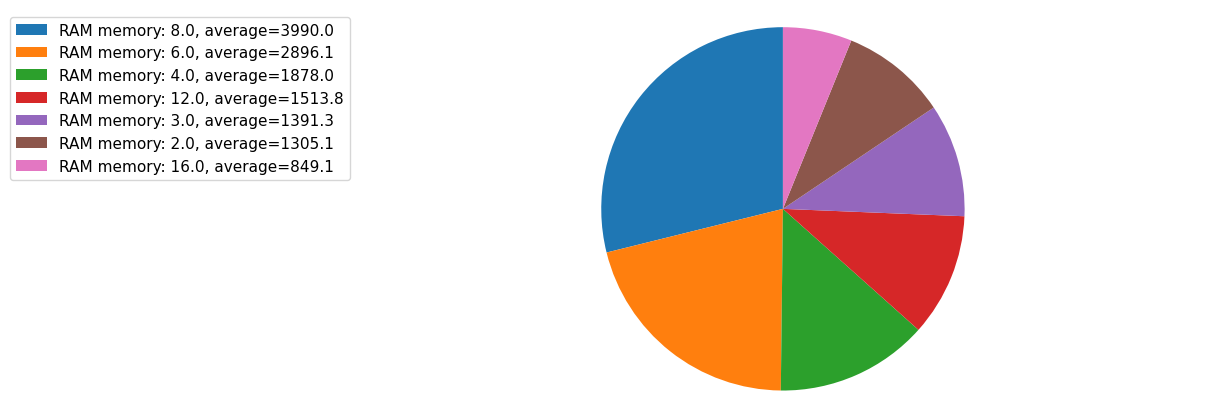

In [40]:
PhonesByProcessor_count = dfUnionPrice['RAM memory'].value_counts()

Phone_price_mean_by_Processor= dfUnionPrice.groupby('RAM memory', as_index=False)['Price'].mean()
Phone_price_mean_by_Processor.sort_values(by="Price", inplace=True, ascending=False)

labels = ["RAM memory: %s" % i for i in PhonesByProcessor_count.index]

fig1, ax1 = plt.subplots(figsize=(12, 4))
fig1.subplots_adjust(0.3,0,1,1)

_, _ = ax1.pie(Phone_price_mean_by_Processor['Price'].tolist(), startangle=90)

ax1.axis('equal')

plt.legend(
    loc='upper left',
    labels=['%s, average=%1.1f' % (
        l, (v)) for l, s, v in zip(labels, Phone_price_mean_by_Processor.index, Phone_price_mean_by_Processor['Price'].tolist())],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()

Lets check how the Brand effects on our mean Price:

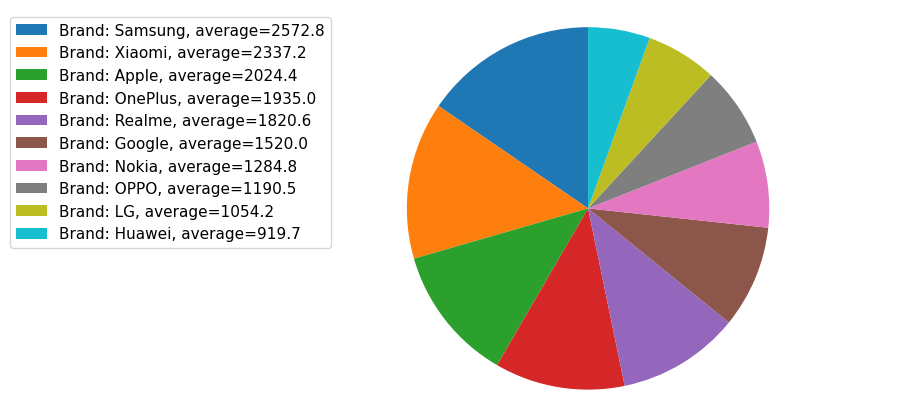

In [41]:
PhonesByProcessor_count = dfUnionPrice['Brand'].value_counts()

Phone_price_mean_by_Processor= dfUnionPrice.groupby('Brand', as_index=False)['Price'].mean()
Phone_price_mean_by_Processor.sort_values(by="Price", inplace=True, ascending=False)

labels = ["Brand: %s" % i for i in PhonesByProcessor_count.index]

fig1, ax1 = plt.subplots(figsize=(9, 4))
fig1.subplots_adjust(0.3,0,1,1)

_, _ = ax1.pie(Phone_price_mean_by_Processor['Price'].tolist(), startangle=90)

ax1.axis('equal')

plt.legend(
    loc='upper left',
    labels=['%s, average=%1.1f' % (
        l, (v)) for l, s, v in zip(labels, Phone_price_mean_by_Processor.index, Phone_price_mean_by_Processor['Price'].tolist())],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()

In [43]:
def train_model(X, y):
    reg = LinearRegression(fit_intercept = False)
    return reg.fit(X, y)

def evaluate_performance(y,y_predicted):
    return metrics.r2_score(y, y_predicted)

def split_to_X_and_y(df, target_column):
    return df.drop([target_column],axis = 1), df[target_column]

def predict(df):
    numeric_df = df.select_dtypes(include='number')
    X, y = split_to_X_and_y(numeric_df,'Price')
    trained_model = train_model(X, y)
    pred_vals = trained_model.predict(X)
    y_pred= pd.Series(pred_vals,index=X.index)
    eval_res = evaluate_performance(y, y_pred)
    print('amount of data:', X.shape[0] * X.shape[1])
    print('prediction:', eval_res)

In [44]:
PhonesMechine=dfUnionPrice.copy()
predict(PhonesMechine)


amount of data: 7200
prediction: 0.8432569713675782
